In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle
from datetime import datetime
%matplotlib notebook

In [2]:
def get_raw_time_series(path='datasets/DJIA.csv'):
    dates = []
    days = []
    close = []
    
    with open(path, newline='') as f:
        reader = csv.reader(f, quotechar='|')
        
        for i, row in enumerate(reader):
            if i == 0:
                continue
            if i == 1:
                init_date = datetime.strptime(row[0], "%Y-%m-%d")
            
            dates.append(row[0])
            days.append((datetime.strptime(row[0], "%Y-%m-%d") - init_date).days)
            close.append(float(row[5]))
            
    return init_date, np.array(days), np.array(close)

In [5]:
start_date, raw_days, raw_close = get_raw_time_series()
print((datetime(2009, 9, 1) - start_date).days)

130


NameError: name 'days' is not defined

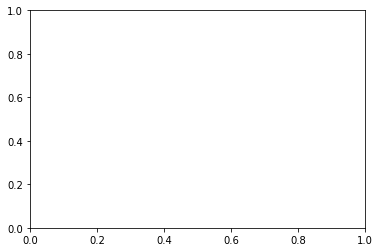

In [6]:
fig, ax = plt.subplots()
ax.plot(days, close)
plt.title("DJIA")

In [7]:
def preprocess_time_series(days, close, SMOOTHING=3):
    N = 1 + max(days)
    new_days = list(range(N))

    new_close = [-1] * N
    for i, day in enumerate(days):
        new_close[day] = close[i]
        
    #Linear interpolation to add values for non-weekdays
    for i in new_days:
        if new_close[i] > 0:
            continue
        
        d = 0
        while new_close[i+d] < 0:
            d += 1
            
        slope = (new_close[i+d] - new_close[i-1]) / (d + 1)
            
        for j in range(d):
            new_close[i+j] = new_close[i-1] + (j + 1) * slope
            
    #Fourier smoothing to remove extremely volatile data points
    dfft = np.fft.fft(new_close)
    dfft[:SMOOTHING] = 0
    new_close = np.real(np.fft.ifft(dfft))
        
    #Convert closing values to z-scores so we're not working with numbers like 10000
    mean = np.mean(new_close)
    sigma = np.std(new_close)
    #new_close = (new_close - mean) / sigma
    
    return new_days, new_close

In [8]:
days, close = preprocess_time_series(raw_days, raw_close, SMOOTHING=0)

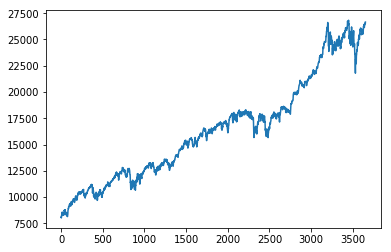

In [9]:
fig, ax = plt.subplots()
ax.plot(days, close)

In [10]:
def load_djia(path="djia_ts.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_djia(ts, path="djia_ts.txt"):
    with open(path, "wb") as f:
        pickle.dump(ts, f, pickle.HIGHEST_PROTOCOL)


In [11]:
save_djia(close)